<div align="center">
  <a href="https://www.davivienda.com/wps/portal/personas/nuevo">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" alt="Logo" width="300" height="100">
  </a>

  <h2 align="center">Prueba Técnica Davivienda ADNe - Especialista I</h2>
  <h2 align="center">Notebook de Implementación Extracción de Opiniones Tweets</h2>
  <h4 align="center">Luvan Tabares</h4>
    
***

  <p align="left">
    Se requiere desarrollar una analítica preliminar de un conjunto de tweets que mencionan a nuestra organización. Utilizando herramientas de procesamiento de lenguaje natural (NLP), se procesarán los textos de los tweets para encontrar insights relevantes para áreas como marketing y servicio al cliente. Se busca visualizar estos datos de forma clara para los tomadores de decisiones y agrupar los tweets en categorías que permitan una buena analítica descriptiva de las opiniones de los clientes en Twitter. Para este desarrollo se usará una potente herramienta de clasificación de tópicos llamada BERTopic, capaz de analizar textos sin necesidad de realizar limpiezas y entendiendo su contexto para elegir los tópicos, siendo capaz de organizar un tópico especial para textos irrelevantes, lo que ayuda a reducir el análisis.
    
  </p>
</div>

## Tabla de contenidos

1. [Instalación de librerías y llamado de librerías](#first) <br />
2. [Pequeña exploración de datos](#second) <br />
3. [Extracción de tópicos](#third) <br />
4. [Análisis de sentimiento](#fourth) <br />
5. [Análisis de resultados](#fifth) <br />

## 1. Librerias a instalar <a id="first"></a>

In [1]:
!pip install -r requirements.txt

  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached bertopic-0.16.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached certifi-2024.7.4-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached contourpy-1.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached Cython-0.29.37-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
  Using cached fastjsonschema-2.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached fonttools-4.53.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached hdbscan-0.8.37-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_

## Cargar las librerías necesarias

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns

from umap import UMAP
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
import re
from transformers import pipeline

import matplotlib.pyplot as plt


## 2. Pequeña exploración de datos <a id="second"></a>

In [3]:
### Se inicia cargando el archivo csv
csv_file_path = 'data_original/Tweets/davivienda_tweets.csv'
### Se carga el archivo csv en un dataframe
df = pd.read_csv(csv_file_path)

In [4]:
# Se imprime el encabezado del dataframe
df.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


### Una vez revisados los textos, normalmente se realiza una limpieza de los mismos. Sin embargo, debido al uso de la herramienta BERTopic, no será necesario realizar preprocesamientos. Al contrario, con este modelo, las StopWords pueden proporcionar un contexto valioso que se perdería si fueran eliminadas. Además, considerando que los textos a analizar son tweets, que son generalmente cortos, eliminar información podría resultar en una pérdida de contexto importante.

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)
# Se revisará la longitud de los tweets
df["headline_text_len"] = df["Embedded_text"].apply(lambda x : len(x.split()))

In [6]:
# La longitud de los tweets máxima y mínima
print("The longest headline has: {} words".format(df.headline_text_len.max()))
print("The shortest headline has: {} words".format(df.headline_text_len.min()))

The longest headline has: 101 words
The shortest headline has: 4 words


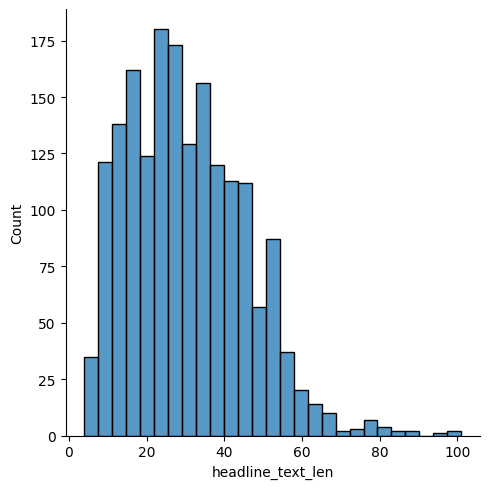

In [7]:
# Se visualiza la distribución de la longitud de los tweets
sns.displot(df.headline_text_len, kde=False)

### En este caso, aunque precipitado, se podría decir que tanto tweets demasiado largos como tweets demasiado cortos no deberían aportar información relevante, siendo ambos casos posibles spams o la citación de múltiples personas en el mismo tweet. Podría considerarse a futuro la eliminación de estos casos con precaución, para este análisis se tomarán todos los casos.

In [8]:
# Ahora se visualizan algunos ejemplos de tweets
for idx in df.sample(3).index:  # Itera sobre los índices de 3 muestras aleatorias del DataFrame df.
    headline = df.iloc[idx]  # Obtiene la fila correspondiente al índice actual.
    print("Headline #{}:".format(idx))  # Imprime el número de la noticia actual.
    print("Publication date: {}".format(headline.Timestamp))  # Imprime la fecha de publicación de la noticia.
    print("Text: {}\n".format(headline.Embedded_text))  # Imprime el texto de la noticia.

Headline #1532:
Publication date: 2021-12-20T21:03:32.000Z
Text: En respuesta a 
@laurigarzon
Buenas tardes, Sra. Laura. Para nosotros es importante la seguridad de nuestros clientes. Por favor escribanos por mensaje privado para realizar el respectivo reporte. Quedamos atentos. Saludos.
1

Headline #1165:
Publication date: 2021-12-17T16:29:16.000Z
Text: La corrupción de tomø a Davivienda. Cuantos estafados, cuántas víctimas, cuántas denuncias....saquen su plática de allí.
Wilson Arias
@wilsonariasc
 · 17 dic.
He conocido de primera mano un caso en el que funcionarios de @Davivienda, con aparente falsificación de firmas, cambiaron cláusulas de un contrato de promesa de compraventa y se terminaron beneficiando de más de $1.000 millones de pesos. Hacen y desasen sin que nadie los vigile.
Mostrar este hilo

Headline #853:
Publication date: 2021-12-15T20:17:03.000Z
Text: @DaviPlata
 Hace 3 semanas estoy esperando respuesta que tardaría 4 días por parte de ustedes. Lo radiqué de nuevo hace 

## 3. Extracción de tópicos <a id="third"></a>

In [9]:
# Continuado con el desarrollo se procede a realizar el análisis de tópicos
# Se crea un modelo UMAP, esto con el fin de tener consistencia en los resultados
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=5)
# Se crea el modelo BERTopic
# Se establece el parámetro embedding_model='paraphrase-MiniLM-L3-v2' para utilizar el modelo de lenguaje MiniLM.
# Se establece el parámetro min_topic_size para que se creen tópicos con un n tweets.
# Se establece el parámetro language="multilingual" para que el modelo sea capaz de procesar texto en varios idiomas.
# Se establece el parámetro nr_topics='auto' para que el modelo determine automáticamente el número de tópicos y evitar tópicos comunes
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 3, language="multilingual", nr_topics='auto', umap_model=umap_model)


# Se ajusta el modelo a los tweets
# Se extraen los tópicos y las palabras clave de los tópicos
headline_topics, _ = model.fit_transform(df.Embedded_text)

2024-07-20 12:53:57,661 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 57/57 [00:00<00:00, 113.70it/s]
2024-07-20 12:53:59,288 - BERTopic - Embedding - Completed ✓
2024-07-20 12:53:59,288 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-20 12:54:08,198 - BERTopic - Dimensionality - Completed ✓
2024-07-20 12:54:08,199 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-20 12:54:08,243 - BERTopic - Cluster - Completed ✓
2024-07-20 12:54:08,243 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-20 12:54:08,327 - BERTopic - Representation - Completed ✓
2024-07-20 12:54:08,328 - BERTopic - Topic reduction - Reducing number of topics
2024-07-20 12:54:08,384 - BERTopic - Topic reduction - Reduced number of topics from 119 to 40


### Durante el desarrollo se observó que ajustar la cantidad de min_topic_size podría mejorar el filtrado de la información. Inicialmente se usaron 10 tópicos mínimos, lo que agrupaba todos los mensajes de Davivienda en una sola categoría, impidiendo la extracción de información relevante. Esto se debe a que Davivienda utiliza una plantilla de respuestas para asistir a los usuarios o disculparse en caso de fallas del servicio. Por esta razón, se redujo el número mínimo de tópicos para mejorar la identificación de temas. Con min_topic_size establecido en 10, los tweets con respuestas tipo plantilla de Davivienda se consideraban como tópicos importantes. Al reducir el valor a 5 o menos, estos mensajes de plantilla aparecieron con el tópico -1, indicando que para el modelo estos mensajes son irrelevantes y, por lo tanto, no deben ser revisados ya que son redundantes. Un problema que se tiene

In [10]:
# Obtener información sobre los temas del modelo
freq = model.get_topic_info()  
# Imprimir el número de temas identificados por el modelo
print("Number of topics: {}".format(len(freq)))  
# Mostrar el DataFrame 'freq' que contiene la información de los temas
freq.head(10)

Number of topics: 40


,Topic,Count,Name,Representation,Representative_Docs
0,-1,537,-1_davivienda_de_en_que,"[davivienda, de, en, que, la, no, me, el, con,...",[Como por la vía telefónica no tenía respuesta...
1,0,923,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...
2,1,61,1_respondiendo_más_edimejia1979_noticiasrcn,"[respondiendo, más, edimejia1979, noticiasrcn,...",[Respondiendo a \n@Edimejia1979\n @NoticiasRCN...
3,2,41,2_página_davivienda_app_la,"[página, davivienda, app, la, ha, mamá, usado,...",[Provablemente alguien del mismo davivienda qu...
4,3,17,3_como_jajajajajajaja_alexillo36_estaba,"[como, jajajajajajaja, alexillo36, estaba, jaj...",[En respuesta a \n@LaLocuraCrece\n y \n@Millos...
5,4,16,4_marianiniecheve_respondiendo_más_augustoocampo,"[marianiniecheve, respondiendo, más, augustooc...",[Respondiendo a \n@Marianiniecheve\n @AUGUSTOO...
6,5,16,5_2021_concierto_colombia_at,"[2021, concierto, colombia, at, december, 05, ...","[December 16, 2021 at 05:09PM. MovilidadTGU.#..."
7,6,15,6_segurosbolivar_marianiniecheve_son_grupo,"[segurosbolivar, marianiniecheve, son, grupo, ...",[En respuesta a \n@Marianiniecheve\n @SegurosB...
8,7,12,7_gracias_muchas_solucionó_pude,"[gracias, muchas, solucionó, pude, dm, respues...",[En respuesta a \n@Margaritarosadf\nGracias b...
9,8,11,8_alegría_optimismo_navidad_decoración,"[alegría, optimismo, navidad, decoración, époc...","[Como es tradición, Banco Davivienda ilumina l..."


### Se observa que la cantidad de tópicos -1 es bastante elevada, en este caso es normal, la única manera de mejorar y reducir la detección de los textos irrelevantes es mejorar la tokenización e incluso probar otros modelos, se intentó usar la tokenización de spacy y el modelo en español pero no hubo mejoras

### En la siguiente celda se puede observar más detalladamente cada texto analizado, con su topic asignado, un nombre, las palabras claves más representativas y otras métricas.

In [11]:
model.get_document_info(df.Embedded_text)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,La confianza se afectó. El indicador de confia...,0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,0.552204,False
1,Buscamos la accesibilidad y mejor atención en ...,0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,1.000000,False
2,Señores \n@Davivienda\n no he podido ingresar ...,15,15_ayudar_me_pueden_ingresar,"[ayudar, me, pueden, ingresar, app, favor, hol...",[Señores \n@Davivienda\n estoy tratando de ing...,ayudar - me - pueden - ingresar - app - favor ...,0.552499,False
3,Llevo toda una semana sufriendo intento de hur...,0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,1.000000,False
4,Hemos retrocedido tanto en este país con este ...,-1,-1_davivienda_de_en_que,"[davivienda, de, en, que, la, no, me, el, con,...",[Como por la vía telefónica no tenía respuesta...,davivienda - de - en - que - la - no - me - el...,0.000000,False
...,...,...,...,...,...,...,...,...
1806,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,0.903872,False
1807,"En respuesta a \n@josefe71\nHola Jose , gracia...",0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,0.654657,False
1808,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,0.272396,False
1809,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",0,0_en_respuesta_de_por,"[en, respuesta, de, por, que, su, davivienda, ...",[En respuesta a \n@Hanso_Hasashi_\nBuenos días...,en - respuesta - de - por - que - su - davivie...,0.869166,False


### Es posible que a pesar de usar filtros como nr_topics='auto' que activa el HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) que es un algoritmo de clustering avanzado con detección con características como: 

### Densidad Variable: HDBSCAN puede identificar clusters en datos con densidades variadas, mientras que DBSCAN requiere una densidad constante.
### Jerarquía de Clusters: HDBSCAN construye una jerarquía de clusters, permitiendo analizar la estructura de los datos a diferentes niveles de granularidad.
### Identificación de Ruido: Al igual que DBSCAN, HDBSCAN puede identificar puntos de datos que no pertenecen a ningún cluster (ruido).
### Automatización de Parámetros: puede automatizar la elección de algunos parámetros que en DBSCAN deben ser ajustados manualmente, como el radio de búsqueda

### Aún con esto se pueden tener topicos duplicados, por lo que se realizará un breve análisis al respecto

In [12]:
### Se visualizan los tópicos y su similaridad, en la gráfica la misma tonalidad sugiere tópicos muy cercanos que se podrían unir
model.visualize_heatmap(n_clusters=len(freq)/2)

In [13]:
# Calcular la similitud coseno entre los embeddings de los temas y almacenarla en una matriz de distancia
distance_matrix = cosine_similarity(np.array(model.topic_embeddings_))

# Convertir la matriz de distancia en un DataFrame para facilitar su manipulación, estableciendo columnas e índice con las etiquetas de los temas
dist_df = pd.DataFrame(distance_matrix, columns=model.topic_labels_.values(), index=model.topic_labels_.values())

# Inicializar una lista vacía para almacenar las distancias por pares entre temas
tmp = []

# Convertir el DataFrame de distancia en un diccionario de registros y iterar sobre él
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']  # El campo 'index' representa el primer tema en el par
    for t2 in rec:  # Iterar sobre todos los temas para calcular distancias por pares
        if t2 == 'index':  # Saltar el campo 'index' ya que no es un tema
            continue
        # Añadir un diccionario con los temas y su distancia a la lista
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

# Convertir la lista de diccionarios en un DataFrame para facilitar su manipulación
pair_dist_df = pd.DataFrame(tmp)

# Filtrar los pares donde alguno de los temas esté etiquetado como '-1' (generalmente representa ruido o temas no clasificados)
pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]

# Asegurar que cada par sea único filtrando duplicados invertidos
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

# Ordenar el DataFrame por distancia en orden descendente y mostrar los 20 pares superiores
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
90,1_respondiendo_más_edimejia1979_noticiasrcn,9_seguros_oscatorex_respondiendo_más,0.884767
63,0_en_respuesta_de_por,22_las_migraña_luces_dejó,0.871202
763,18_llane_sera_novela_quieneslamascaracolombia,2_página_davivienda_app_la,0.862317
72,0_en_respuesta_de_por,31_crecimiento_suministro_lastrar_pmi,0.861492
523,12_just_servicio_single_haven,2_página_davivienda_app_la,0.857066
85,1_respondiendo_más_edimejia1979_noticiasrcn,4_marianiniecheve_respondiendo_más_augustoocampo,0.856030
65,0_en_respuesta_de_por,24_niño_037700055686_oscar_lasso,0.854334
603,14_lugar_equivocado_jue_sentí,2_página_davivienda_app_la,0.851668
679,15_ayudar_me_pueden_ingresar,38_fallas_ingresar_ingresados_cambié,0.849983
1123,27_usaré_matecaña_omeeeee_dejo,2_página_davivienda_app_la,0.847949


### Se observan que hasta arriba algunos temas podrían ser efectivamente similares, por lo que se podrían unir para reducir la cantidad de tópicos

In [14]:
# Se define función para extraer los números de los temas con una distancia superior a 0.9
def extract_numbers(row):
    # Si la distancia entre los temas es mayor a 0.9
    if row['distance'] > 0.9:
        # Extrae el número del primer tema usando expresiones regulares y lo convierte a entero
        num1 = int(re.match(r'(\d+)_', row['topic1']).group(1))
        # Extrae el número del segundo tema usando expresiones regulares y lo convierte a entero
        num2 = int(re.match(r'(\d+)_', row['topic2']).group(1))
        # Retorna una lista con los números extraídos
        return [num1, num2]
    else:
        # Si la distancia es menor o igual a 0.9, retorna una lista vacía
        return []

# Aplica la función a cada fila del DataFrame y crea una nueva columna 'numbers' con la lista de números
pair_dist_df['numbers'] = pair_dist_df.apply(extract_numbers, axis=1)

In [15]:
# Convertir la columna 'numbers' del DataFrame en una lista de listas
lista_temas_similares = pair_dist_df['numbers'].tolist()
# Filtrar la lista para eliminar las listas vacías, manteniendo solo aquellas con números de temas similares
filtered_lista_temas_similares = [lst for lst in lista_temas_similares if lst]
# Utilizar el modelo para fusionar los temas en el DataFrame 'df' basado en los números de temas similares identificados
try:
    model.merge_topics(df.Embedded_text, filtered_lista_temas_similares)

    # Actualiza el modelo con los temas fusionados para obtener la distribución de temas y tokens
    # Se utiliza la función approximate_distribution del modelo
    topic_distr, topic_token_distr = model.approximate_distribution(
        df.Embedded_text,  # Se pasa el texto embebido del DataFrame como entrada
        window = 4,  # Se define una ventana de 4 para considerar el contexto local alrededor de cada palabra
        calculate_tokens=True)  # Se habilita el cálculo de la distribución de tokens además de la de temas

except Exception as e:
    print("No hubo necesidad de fusionar temas similares, los temas no superaron el 90% de similitud")

No hubo necesidad de fusionar temas similares, los temas no superaron el 90% de similitud


In [16]:
# Ahora se pueden extraer las primeras dos palabras de cada tópico para generar nombres de tópicos más descriptivos
def extract_first_two_words(word_list):
    return " ".join(word_list[:2])

In [17]:
#Se asigna una variable a la lista de tópicos
df_topics = model.get_document_info(df.Embedded_text)
# Se añade la columna 'Topic' al DataFrame reemplazando los números por palabras descriptivas
df['Topic'] = df_topics['Representation'].apply(extract_first_two_words)

In [18]:
topic_outlier = df_topics[df_topics['Topic'] == -1]
topic_outlier['Topic'] = topic_outlier['Representation'].apply(extract_first_two_words)
topic_outlier = topic_outlier.reset_index(drop=True)['Topic'][0]

# Finalmente se visualiza el tópico outlier, que es el tópico que no se ha podido clasificar o que según el modelo
# no sería relevante para el análisis casi considerandolo spam, aunque es importante intentar reducir al máximo estos tópicos
# pero evitando llegar al punto de forzar al modelo a clasificar el mensaje en un tópico que no le corresponde
print("Outlier topic: {}".format(topic_outlier))

Outlier topic: davivienda de


In [19]:
# Se revisa si la cantidad de tópicos disminuyó en caso de que se hayan fusionado tópicos similares
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))

Number of topics: 40


### En la siguiente celda se puede observar la columna Topic agregada al dataframe

In [20]:
df.drop_duplicates(subset=['Topic']).head(10)

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,headline_text_len,Topic
0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,45,en respuesta
2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...,25,ayudar me
4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...,34,davivienda de
7,Cristian Julian,@cjulianlozano,2021-12-01T00:01:49.000Z,Cristian Julian\n@cjulianlozano\n·\n30 nov.,Mamado de ser adulto y tener que trabajar para...,NaN,NaN,NaN,NaN,[],https://twitter.com/cjulianlozano/status/14658...,12,lugar equivocado
12,Juliana,@JulianaUssa3,2021-12-01T17:33:05.000Z,Juliana\n@JulianaUssa3\n·\n1 dic.,Nunca usen los servicios de \n@DaviPlata\n @Ra...,NaN,2.0,NaN,1,[],https://twitter.com/JulianaUssa3/status/146609...,18,nunca desastrosa
13,DATAiFX,@dataiFX,2021-12-01T16:29:06.000Z,DATAiFX\n@dataiFX\n·\n1 dic.,Problemas de suministro volvieron a lastrar el...,NaN,NaN,2,1,['https://pbs.twimg.com/media/FFiRrQpXIAIAg7C?...,https://twitter.com/dataiFX/status/14660819344...,19,crecimiento suministro
14,Andrea Cabana D.,@andreaCabanaD,2021-12-01T13:24:36.000Z,Andrea Cabana D.\n@andreaCabanaD\n·\n1 dic.,Me quiero ir de \n@Bancolombia\n. Pero no a Da...,NaN,3.0,NaN,NaN,[],https://twitter.com/andreaCabanaD/status/14660...,13,bancolombia virtualmente
15,DATAiFX,@dataiFX,2021-12-01T13:14:39.000Z,DATAiFX\n@dataiFX\n·\n1 dic.,#LiveDataiFX Lo que hoy debe saber I Daviviend...,NaN,NaN,NaN,NaN,['https://pbs.twimg.com/media/FFhlPkvXsAI5jid?...,https://twitter.com/dataiFX/status/14660329989...,13,loquehoydebesaber livedataifx
19,Simon Nariño,@simonnarino,2021-12-01T21:43:51.000Z,Simon Nariño\n@simonnarino\n·\n1 dic.,@Davivienda\n en todo el día no he podido acce...,NaN,2.0,NaN,1,[],https://twitter.com/simonnarino/status/1466161...,21,virtuales canales
21,JUAN BERNAL,@jsbgm,2021-12-01T14:15:51.000Z,JUAN BERNAL\n@jsbgm\n·\n1 dic.,@Davivienda\n para cuando Apple Pay?\n1\n4,NaN,1.0,NaN,4,[],https://twitter.com/jsbgm/status/1466048400529...,7,apple pay


## 4. Análisis de sentimiento <a id="fourth"></a>

### En Hugging Face se encontró el modelo pysentimiento/robertuito-sentiment-analysis que es un modelo entrenado en español para detectar el sentimiento de los tweets, modelo entrenado con alrededor de 5000 tweets lo hace un modelo interesante para analizar los sentimientos en un tweet en español

In [21]:
# Crear un analizador de sentimientos utilizando la pipeline de 'sentiment-analysis'
# Se especifica el modelo 'pysentimiento/robertuito-sentiment-analysis' para análisis de sentimiento en español
# Se asigna el proceso al dispositivo con ID 0 (generalmente la primera GPU disponible)
sentiment_analyzer = pipeline('sentiment-analysis', model='pysentimiento/robertuito-sentiment-analysis', device=0)

# Convertir la columna 'Embedded_text' del DataFrame df en una lista
# Esta lista contendrá los textos a analizar
texts = df['Embedded_text'].tolist()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Debido a limitaciones del modelo de sentimiento utilizado se debe recortar un poco los mensajes, para no sobrepasar el límite de tokens de 128, para esto se eliminarán caracteres especiales, saltos de línea y espacios grandes, para así evitar eliminar tantas palabras.

In [22]:
# Se realiza un pequeño preprocesamiento a los textos
for i in range(len(texts)):  # Iterar sobre cada texto en la lista 'texts'
    texts[i] = texts[i].replace("@", "")  # Eliminar el carácter '@' de los textos
    texts[i] = texts[i].replace("#", " ")  # Reemplazar el carácter '#' por un espacio en blanco
    texts[i] = texts[i].replace("\n", " ")  # Reemplazar los saltos de línea por espacios en blanco
    # Usar una expresión regular para reemplazar múltiples espacios por un solo espacio y eliminar espacios al inicio y al final
    texts[i] = re.sub(r"\s+", " ", texts[i]).strip()

### Ahora se realiza la inferencia sobre los textos, para este caso se usó GPU

In [23]:
# Cargar la pipeline de análisis de sentimiento con el modelo Robertuito
sentiment_analyzer = pipeline("sentiment-analysis", model="pysentimiento/robertuito-sentiment-analysis", device=0)

max_length = 128  # Definir la longitud máxima del texto a analizar

sentiment_list = []  # Inicializar una lista para almacenar los resultados del análisis de sentimiento
# Analizar el sentimiento de cada texto
for text in texts:
    try:
        # Truncar el texto a la longitud máxima permitida
        truncated_text = text[:max_length]
        # Realizar el análisis de sentimiento en el texto truncado
        result = sentiment_analyzer(truncated_text)[0]
        label = result['label']  # Extraer la etiqueta del resultado (POS, NEG, NEU)
        sentiment_list.append(label)  # Añadir la etiqueta a la lista de sentimientos
    except Exception as e:  # Capturar cualquier excepción durante el análisis
        print("Error al analizar el sentimiento")  # Imprimir mensaje de error
        print(e)  # Imprimir la excepción
        print(f"Texto: {text}")  # Imprimir el texto que causó la excepción
        sentiment_list.append("Error")  # Añadir "Error" a la lista de sentimientos para este texto

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### Ahora tenemos la lista de sentimientos para cada texto y se agregará al Dataframe

In [24]:
df['Sentimiento'] = sentiment_list

In [25]:
df

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,headline_text_len,Topic,Sentimiento
0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,45,en respuesta,NEG
1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...,32,en respuesta,NEU
2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...,25,ayudar me,NEG
3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...,52,en respuesta,NEG
4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...,34,davivienda de,NEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,Banco Davivienda,@Davivienda,2021-12-22T18:26:38.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737216...,38,en respuesta,NEU
1807,Banco Davivienda,@Davivienda,2021-12-22T20:18:40.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@josefe71\nHola Jose , gracia...",NaN,1.0,NaN,NaN,[],https://twitter.com/Davivienda/status/14737498...,45,en respuesta,POS
1808,Banco Davivienda,@Davivienda,2021-12-22T17:54:45.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,👋,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14737136...,37,en respuesta,NEU
1809,Banco Davivienda,@Davivienda,2021-12-22T11:45:13.000Z,Banco Davivienda\n@Davivienda\n·\n22 dic.,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",NaN,NaN,NaN,NaN,[],https://twitter.com/Davivienda/status/14736206...,28,en respuesta,NEU


## 5. Análisis de resultados <a id="fifth"></a>

### Se procede a contar la cantidad de mensajes positivos, negativos o neutros. Normalmente las personas no tienden a mostrar su aprobación por una empresa en redes sociales, si una persona habla de alguna empresa en redes sociales es para quejarse o criticar, por lo que se esperan una gran cantidad de mensajes negativos

### Se observa que en efecto la mayor cantidad de mensajes son negativos, teniendo 859 mensajes negativos, 835 neutros y solo 117 positivos.

In [26]:
# Contar la frecuencia de cada valor único en la columna 'Sentimiento' del DataFrame df
sentiment_counts = df['Sentimiento'].value_counts()
# Imprimir el recuento de frecuencias para cada categoría de sentimiento
print(sentiment_counts)

Sentimiento
NEG    859
NEU    835
POS    117
Name: count, dtype: int64


### Analizando en términos de porcentajes se llega a un 47.43% de mensajes negativos y un 46.10% de mensajes neutros

In [27]:
# Calcular el total de entradas en el DataFrame df
total_count = len(df)
# Calcular los porcentajes de cada categoría de sentimiento dividiendo los conteos de sentimientos por el total de entradas y multiplicando por 100
sentiment_percentages = (sentiment_counts / total_count) * 100
# Imprimir los porcentajes de sentimientos para visualizar la distribución de sentimientos en el DataFrame
print(sentiment_percentages)

Sentimiento
NEG    47.432358
NEU    46.107123
POS     6.460519
Name: count, dtype: float64


### Ahora se organiza por tópicos y se calcula cada tópico cuantos mensajes positivos, negativos y neutros existen

In [28]:
# Agrupar el DataFrame 'df' por la columna 'Topic' y contar los valores únicos de 'Sentimiento' para cada tema
# La función 'unstack' convierte el resultado en un DataFrame donde cada columna representa una categoría de sentimiento
# 'fill_value=0' asegura que los valores faltantes se rellenen con 0
topic_sentiment_counts = df.groupby('Topic')['Sentimiento'].value_counts().unstack(fill_value=0)

In [29]:
topic_sentiment_counts.head(10)

Sentimiento,NEG,NEU,POS
Topic,,,
15 días,3,0,0
2021 concierto,0,9,7
3206981098 daniela,0,3,0
alegría optimismo,0,4,7
apple pay,1,5,0
ayudar me,4,4,0
bancolombia virtualmente,2,7,0
cajeros plata,5,0,0
como jajajajajajaja,3,13,1


### Esta tabla no nos suministra mucha información al respecto, por lo que se organizará para que se muestren los topicos con mas reseñas negativas

In [30]:
# Obtener los conteos de sentimientos negativos ('NEG') para cada tema del DataFrame 'topic_sentiment_counts'
negative_counts = topic_sentiment_counts['NEG']
# Ordenar los temas por conteos negativos en orden descendente
sorted_topics = negative_counts.sort_values(ascending=False)
# Reordenar el DataFrame 'topic_sentiment_counts' según el orden de los temas ordenados por conteos negativos
sorted_topic_sentiment_counts = topic_sentiment_counts.loc[sorted_topics.index]

In [31]:
sorted_topic_sentiment_counts.head(11)

Sentimiento,NEG,NEU,POS
Topic,,,
en respuesta,410,463,50
davivienda de,307,196,34
página davivienda,29,9,3
respondiendo más,21,38,2
virtuales canales,8,1,0
just servicio,6,2,1
llamando queja,6,2,0
cajeros plata,5,0,0
marianiniecheve respondiendo,5,11,0


### Con la tabla anterior se observa los tópicos organizados por comentarios negativos hacia la organización, el primer caso "en respuesta" se debe a dos cosas, los retweets que están contaminando eso, y en en próximo análisis se deberían eliminar o usar esa base para un nuevo análsis de tópicos ya que es una buena cantidad de información y el otro es las respuestas plantilla Davivienda que colocan asesores de redes sociales para obtener más información y solucionar problemas de algún cliente puntual, esta categoría se debería analizar en mayor profundidad. El segundo caso "davivienda de" son lo que en el modelo se conoce como outlier, una categoria auxiliar llamada "-1" para mandar todos esos textos que no entran en ninguna clasificación e incluso podrían ser considerados spam para no analizar. Y los otros tópicos como página davivienda, virtuales canales, just servicio, llamando queja, cajeros plata, servicios atencion son topicos muy relevantes para la organización, estos deberían analizarse con detaller para determinar cuáles fueron las quejas y si el asesor logró resolver la inquietud del cliente. Por lo que de los 1800 tweets se contraron 59 casos de especial interés.

### Lo siguiente es ver como es el comportamiento de los comentarios negativos para las fechas, a ver que días hubo picos de negatividad hacia la organización

In [32]:
# Convertir la columna 'Timestamp' del DataFrame 'df' a tipo datetime para facilitar la manipulación de fechas
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# Crear una nueva columna 'Date' extrayendo solo la fecha de la columna 'Timestamp'
df['Date'] = df['Timestamp'].dt.date
# Filtrar el DataFrame 'df' para obtener solo las filas donde el sentimiento es negativo ('NEG')
neg_df = df[df['Sentimiento'] == 'NEG']
# Contar la cantidad de textos negativos por fecha y ordenar por fecha
neg_counts = neg_df['Date'].value_counts().sort_index()
# Crear un rango de fechas desde la fecha mínima hasta la máxima presente en la columna 'Date'
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
# Reindexar el conteo de textos negativos para incluir todos los días en el rango de fechas, llenando los días sin datos con 0
neg_counts = neg_counts.reindex(date_range, fill_value=0)

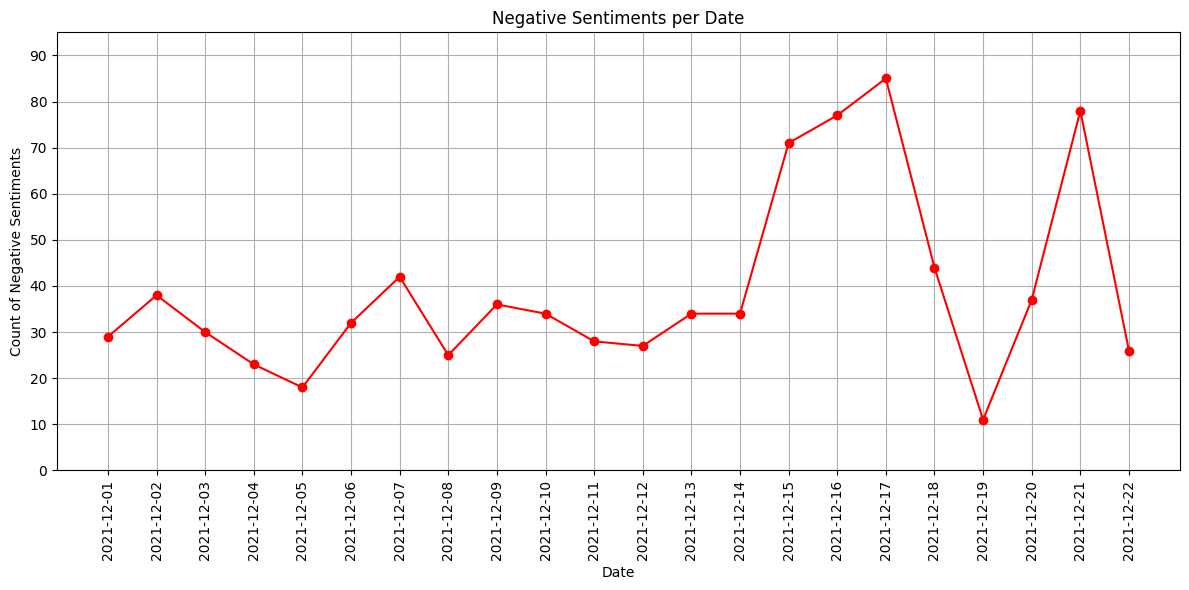

In [33]:
# Crear una figura con dimensiones específicas para el gráfico
plt.figure(figsize=(12, 6))
# Dibujar un gráfico de línea para mostrar los conteos de sentimientos negativos por fecha
# Se utiliza un marcador 'o', una línea sólida y el color rojo para la línea
plt.plot(neg_counts.index, neg_counts.values, marker='o', linestyle='-', color='red')
# Establecer la etiqueta del eje x como 'Date'
plt.xlabel('Date')
# Establecer la etiqueta del eje y como 'Count of Negative Sentiments'
plt.ylabel('Count of Negative Sentiments')
# Establecer el título del gráfico como 'Negative Sentiments per Date'
plt.title('Negative Sentiments per Date')
# Configurar las marcas del eje x para mostrar cada fecha con una rotación de 90 grados para mejorar la legibilidad
plt.xticks(ticks=neg_counts.index, labels=neg_counts.index.strftime('%Y-%m-%d'), rotation=90)
# Establecer los límites del eje y desde 0 hasta el conteo máximo de sentimientos negativos más un margen
plt.ylim(0, neg_counts.max() + 10)
# Configurar las marcas del eje y para mostrar cada 10 unidades
plt.yticks(range(0, int(neg_counts.max()) + 11, 10))
# Habilitar la cuadrícula para mejorar la legibilidad del gráfico
plt.grid(True)
# Ajustar el layout para hacer espacio para las etiquetas del eje x rotadas
plt.tight_layout()
# Mostrar el gráfico
plt.show()

### En el gráfico se observa que el 17 de diciembre del año 2021 se tuvo un pico muy elevado de comentarios negativos, lo mismo pasó el 21 de diciembre del mismo año, se debería tener en cuenta este par de fechas y analizar el porqué pasó eso. De forma preliminar se podría filtrar esas dos fechas y revisar que topicos fueron los que mas comentarios negativos arrojaron

In [34]:
# Convertir la columna 'Date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Definir las fechas de interés
dates_of_interest = ['2021-12-17', '2021-12-21']

# Inicializar un diccionario para almacenar los DataFrames filtrados y procesados
dfs = {}

# Iterar sobre cada fecha de interés
for date in dates_of_interest:
    # Filtrar el DataFrame original para obtener solo las filas que coinciden con la fecha actual
    # y cuyo sentimiento es NEG, POS o NEU
    filtered_df = df[
        (df['Date'].dt.strftime('%Y-%m-%d') == date) & 
        (df['Sentimiento'].isin(['NEG', 'POS', 'NEU']))
    ]
    
    # Agrupar el DataFrame filtrado por 'Topic' y 'Sentimiento', y contar el número de ocurrencias
    count_df = filtered_df.groupby(['Topic', 'Sentimiento']).size().unstack(fill_value=0)

    # Añadir una columna 'NEG_count' que es una copia de la columna 'NEG'
    count_df['NEG_count'] = count_df['NEG']

    # Ordenar el DataFrame por la columna 'NEG_count' de forma descendente
    sorted_df = count_df.sort_values(by='NEG_count', ascending=False)
    
    # Eliminar la columna 'NEG_count' después de ordenar
    sorted_df = sorted_df.drop(columns='NEG_count')

    # Almacenar el DataFrame procesado en el diccionario, usando la fecha como clave
    dfs[date] = sorted_df

# Extraer los DataFrames procesados para las fechas de interés específicas
df_2021_12_17 = dfs['2021-12-17']
df_2021_12_21 = dfs['2021-12-21']

### Ahora se observa el filtrado para cada fecha

In [35]:
df_2021_12_17.head(11)

Sentimiento,NEG,NEU,POS
Topic,,,
en respuesta,57,67,5
davivienda de,20,22,2
página davivienda,2,0,0
respondiendo más,2,9,0
empresas bancolombia,1,0,0
just servicio,1,0,0
servicios atención,1,0,0
usaré matecaña,1,0,0
3206981098 daniela,0,1,0


In [36]:
df_2021_12_21.head(11)

Sentimiento,NEG,NEU,POS
Topic,,,
en respuesta,34,59,1
davivienda de,31,16,3
página davivienda,5,1,1
respondiendo más,1,3,1
equivocado lugar,1,0,0
fallas ingresar,1,0,0
segurosbolivar marianiniecheve,1,0,0
ingresar algoo,1,0,0
just servicio,1,0,0


### Revisando la información se ve que para ambas fechas realmente no hay un crecimiento de algún tópico relacionado al servicio para decir que realmente algo estuvo fallando esos días, para ambas fechas el topico mayor es en respuesta, que puede ser tanto un retweet como una respuesta plantilla de Davivienda, por lo que realmente no se evidencian a simple vista fallas por parte del banco, para esos días se resaltaron pocas menciones a la página davivienda por lo que probablemente eran problemas puntuales de clientes al intentar acceder a la página.

### Otro caso a analizar es filtrar el df por la cantidad de retweets generados, normalmente los retweets serían una forma de alcance de alguna información, y podría también indicar que la persona que da retweet está de acuerdo con lo mencionado por el tweet original, por lo que sería pertinente revisar que tweets tienen la mayor cantidad de retweets y ver a que tópico hace referencia

In [37]:
df['Retweets'] = pd.to_numeric(df['Retweets'], errors='coerce')
df_retweets = df.sort_values(by='Retweets', ascending=False)

### Se tomarán los 20 primeros tweets con mayor cantidad de retweets

In [38]:
df_retweets = df_retweets.reset_index(drop=True)
df_retweets = df_retweets[:20]

In [39]:
df_retweets.head(20)

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,headline_text_len,Topic,Sentimiento,Date
0,Alejandro Betancurth,@AlejoBetancurt7,2021-12-22 17:35:04+00:00,Alejandro Betancurth\n@AlejoBetancurt7\n·\n22 ...,"Fajardo no hace con alianza con Petro porque, ...",NaN,5.0,326,855.0,[],https://twitter.com/AlejoBetancurt7/status/147...,48,en respuesta,NEG,2021-12-22
1,Beatriz Torres,@Beatriz14470382,2021-12-17 16:18:21+00:00,Beatriz Torres\n@Beatriz14470382\n·\n17 dic.,Urge re estructuración al interior del \n@CeDe...,😡,16.0,115,252.0,[],https://twitter.com/Beatriz14470382/status/147...,38,davivienda de,NEG,2021-12-17
2,Hernán Peláez Restrepo,@eldoctorpelaez,2021-12-02 19:13:12+00:00,Hernán Peláez Restrepo\n@eldoctorpelaez\n·\n2 ...,Cada vez que me encuentro a Willington Ortíz l...,NaN,6.0,16,171.0,[],https://twitter.com/eldoctorpelaez/status/1466...,26,en respuesta,NEU,2021-12-02
3,Andrés Cepeda,@andrescepeda,2021-12-11 22:26:44+00:00,Andrés Cepeda\n@andrescepeda\n·\n11 dic.,Gran concierto de Navidad \n@Davivienda\n \nht...,NaN,13.0,14,123.0,[],https://twitter.com/andrescepeda/status/146979...,9,página davivienda,NEU,2021-12-11
4,morat archives,@moratarchive,2021-12-05 22:32:00+00:00,morat archives\n@moratarchive\n·\n5 dic.,– Hoy hace un año. \n¡Morat presentaba el conc...,NaN,NaN,19,89.0,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/moratarchive/status/146762...,22,2021 concierto,POS,2021-12-05
5,Cinthya Quiñones,@CinthyQuinones,2021-12-11 22:19:26+00:00,Cinthya Quiñones\n@CinthyQuinones\n·\n11 dic.,Gran Concierto \n@Davivienda\n Navidad 2021 co...,🌲,3.0,6,60.0,['https://pbs.twimg.com/media/FGXB1CvXIAEfHNy?...,https://twitter.com/CinthyQuinones/status/1469...,19,2021 concierto,POS,2021-12-11
6,Ma.Margarita Giraldo,@MariaMarGiraldo,2021-12-11 22:20:42+00:00,Ma.Margarita Giraldo\n@MariaMarGiraldo\n·\n11 ...,Gracias \n@CaracolTV\n por ese precioso concie...,NaN,NaN,5,48.0,[],https://twitter.com/MariaMarGiraldo/status/146...,16,davivienda de,POS,2021-12-11
7,Chavelly Jiménez,@ChavellyJimenez,2021-12-07 20:18:26+00:00,Chavelly Jiménez\n@ChavellyJimenez\n·\n7 dic.,Bancolombia tiene problemas técnicos serios fr...,NaN,4.0,10,43.0,[],https://twitter.com/ChavellyJimenez/status/146...,40,en respuesta,NEG,2021-12-07
8,Nilson Javier,@IlsonJavier,2021-12-06 00:13:12+00:00,Nilson Javier\n@IlsonJavier\n·\n5 dic.,"En respuesta a \n@RoyBarreras\nPero, jummm, vi...",😩 🥴,3.0,29,38.0,['https://pbs.twimg.com/media/FF4iVVOXwA0wbGA?...,https://twitter.com/IlsonJavier/status/1467648...,51,en respuesta,NEG,2021-12-06
9,Victoria Mejía.,@VictoriaMejiaM,2021-12-22 18:03:16+00:00,Victoria Mejía.\n@VictoriaMejiaM\n·\n22 dic.,Odio el invierno y a \n@Davivienda\n por no co...,NaN,1.0,NaN,25.0,['https://pbs.twimg.com/media/FHOwkvrXIAIFK9m?...,https://twitter.com/VictoriaMejiaM/status/1473...,16,davivienda de,NEG,2021-12-22


### Ahora se vuelve a clasificar por tópicos y su sentimiento

In [40]:
# Contar la frecuencia de cada valor único en la columna 'Sentimiento' del DataFrame
sentiment_counts_retweet = df_retweets['Sentimiento'].value_counts()
# Imprimir el recuento de frecuencias para cada categoría de sentimiento
print(sentiment_counts_retweet)

Sentimiento
NEG    13
NEU     4
POS     3
Name: count, dtype: int64


In [41]:
# Calcular el total de entradas en el DataFrame df
total_count = len(df_retweets)
# Calcular los porcentajes de cada categoría de sentimiento dividiendo los conteos de sentimientos por el total de entradas y multiplicando por 100
sentiment_percentages = (sentiment_counts_retweet / total_count) * 100
# Imprimir los porcentajes de sentimientos para visualizar la distribución de sentimientos en el DataFrame
print(sentiment_percentages)

Sentimiento
NEG    65.0
NEU    20.0
POS    15.0
Name: count, dtype: float64


In [42]:
# Agrupar el DataFrame 'df' por la columna 'Topic' y contar los valores únicos de 'Sentimiento' para cada tema
# La función 'unstack' convierte el resultado en un DataFrame donde cada columna representa una categoría de sentimiento
# 'fill_value=0' asegura que los valores faltantes se rellenen con 0
topic_sentiment_counts = df_retweets.groupby('Topic')['Sentimiento'].value_counts().unstack(fill_value=0)

In [43]:
# Obtener los conteos de sentimientos negativos ('NEG') para cada tema del DataFrame 'topic_sentiment_counts'
negative_counts = topic_sentiment_counts['NEG']
# Ordenar los temas por conteos negativos en orden descendente
sorted_topics = negative_counts.sort_values(ascending=False)
# Reordenar el DataFrame 'topic_sentiment_counts' según el orden de los temas ordenados por conteos negativos
sorted_topic_sentiment_counts = topic_sentiment_counts.loc[sorted_topics.index]

In [44]:
sorted_topic_sentiment_counts

Sentimiento,NEG,NEU,POS
Topic,,,
en respuesta,7,2,0
davivienda de,5,0,1
como jajajajajajaja,1,0,0
2021 concierto,0,0,2
crédito desembolsó,0,1,0
página davivienda,0,1,0


### En este caso los topicos más mencionados son en respuesta, davivienda de, recordando que davivienda de es como un filtro de no categorizados solo nos queda como topico importante en respuesta, que la mayoría de los casos son retweets a otros tweets y podrían no ser relevantes, aunque como la categoría en respuesta es muy amplia se recomendaría seguir con un desarrollo que que también extraiga los tópicos de dichos textos y así tener mayor información de a que se responde.